In [1]:
import pandas as pd
from tpx3awkward import add_centroid_cols
import skbeam.core.correlation as corr
import sparse_code as sparse_code
import importlib
from fast_histogram import histogram1d, histogram2d
import time as time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mpl_colors

tpx_data_fpath = '/nsls2/users/jgoodrich/proposals/2025-1/bdt-commissioning/tpx3data_manual/manual3000000_cent.h5'
dfs = []
for i in range(5):
    tpx_data_fpath = f'/nsls2/users/jgoodrich/proposals/2025-1/bdt-commissioning/tpx3data_manual/manual300000{i}_cent.h5'
    dfs.append(add_centroid_cols(pd.read_hdf(tpx_data_fpath)))

df = pd.concat(dfs).reset_index()

df = df.head(int(len(df) * 0.25))

In [2]:
df

,index,t,xc,yc,ToT_max,ToT_sum,n,x,y,t_ns
0,0,8903922,260.0,52.000000,275,275,1,260,52,1.391238e+07
1,1,8903922,67.0,34.000000,325,325,1,67,34,1.391238e+07
2,2,8903924,34.0,153.000000,100,100,1,34,153,1.391238e+07
3,3,8903927,77.0,24.000000,275,275,1,77,24,1.391239e+07
4,4,8903933,24.0,13.000000,25,25,1,24,13,1.391240e+07
...,...,...,...,...,...,...,...,...,...,...
25314737,5170432,806760254,36.0,67.000000,325,325,1,36,67,1.260563e+09
25314738,5170433,806760265,297.0,76.000000,325,325,1,297,76,1.260563e+09
25314739,5170434,806760358,75.0,132.352936,275,425,2,75,132,1.260563e+09
25314740,5170435,806760371,113.0,44.000000,375,375,1,113,44,1.260563e+09


In [3]:
det_mask = np.load('timepix_bool_mask.npy') # load

In [4]:
wavelength = 1.284810346
detector_distance = 16.5
pixel_distance = 200
pixel_size = 55e-6
k_B = 1.380649e-23  # J/K
T = 298.15  # K
eta = 0.001  # Pa·s (water at room temp)
a = 250e-9  # m (250 nm particle)

def recommend_multi_tau_from_frames(N_frames, tbin_us, default_num_bufs=32):
    T = N_frames * tbin_us * 1e-6  # total time in seconds
    desired_max_lag = T / (tbin_us * 1e-6)  # maximum lag in bins (frames)
    num_levels = int(np.ceil(np.log2((desired_max_lag * 2) / default_num_bufs)))
    return num_levels, default_num_bufs

def q_magnitude(wavelength, detector_distance, pixel_distance, pixel_size):
    R = pixel_distance * pixel_size  # Convert pixel distance to meters
    theta = 0.5 * np.arctan(R / detector_distance)  # Scattering angle
    q = (4 * np.pi / wavelength) * np.sin(theta)  # q magnitude
    return q

def calculate_D0(k_B, T, eta, a):
    return (k_B * T) / (6 * np.pi * eta * a)


def calculate_tau(D_0, q):
    return 1 / (D_0 * q**2)


def calculate_g2(t_values, tau, beta=0.8):
    return 1 + beta * np.exp(-2 * t_values / tau)
    

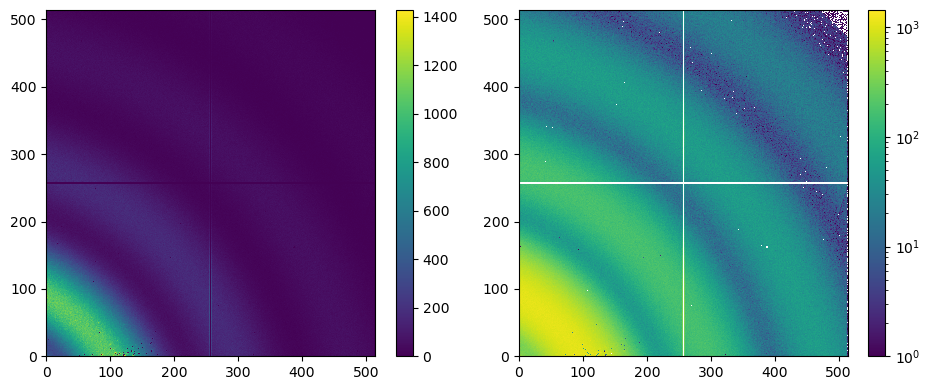

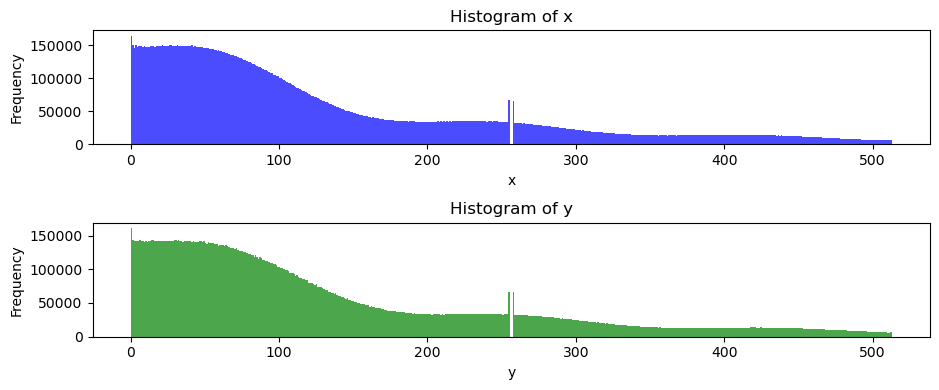

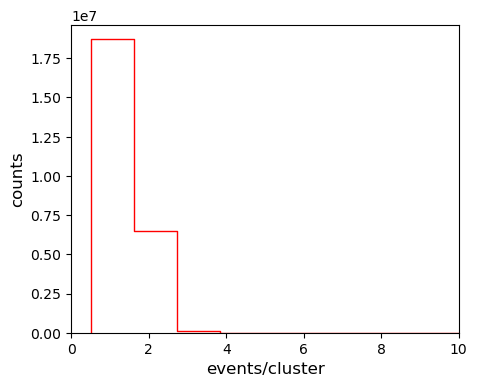

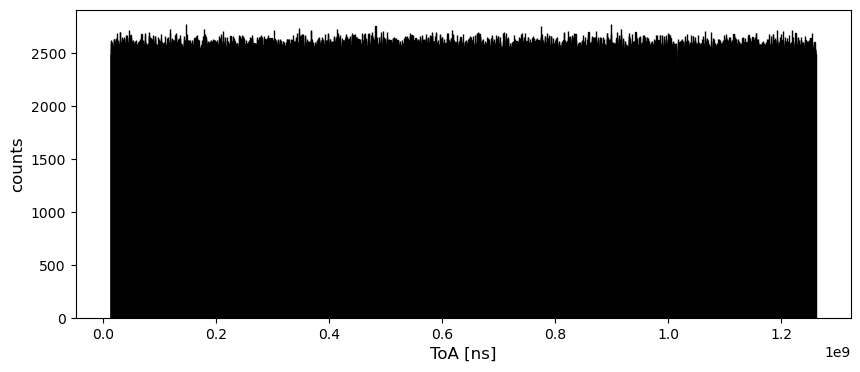

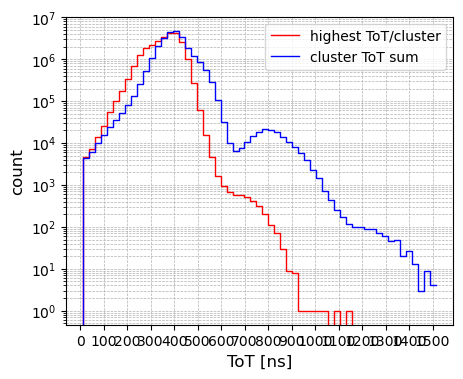

Basic plots done after 6.4 seconds.


In [5]:
ts = time.time()

nbins = 514
npixels = 514

hist_data = histogram2d(df['xc'], df['yc'], range=[[0, 513], [0, 513]], bins=npixels)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))
h = ax0.pcolormesh(hist_data)
fig.colorbar(h, ax = ax0)
h = ax1.pcolormesh(hist_data, norm=mpl.colors.LogNorm())
fig.colorbar(h, ax = ax1)
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(9.5, 4))
axs[0].hist(df['xc'], bins=514, color='blue', alpha=0.7)
axs[0].set_title('Histogram of x')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Frequency')
axs[1].hist(df['yc'], bins=514, color='green', alpha=0.7)
axs[1].set_title('Histogram of y')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

nbins = 10
dmin = 0
dmax = 10
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1]-bins[0]
bshift = bsize/2
hist_data = histogram1d(df['n'], bins = nbins, range = [dmin, dmax])
bins = np.linspace(dmin, dmax, nbins)
fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
plt.step(bins+0.5, hist_data, 'r', linewidth = 1)
plt.ylim([0, np.max(hist_data)*1.05])
plt.xlim([dmin, dmax])
plt.xlabel('events/cluster',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

nbins = 10000
dmin = df['t_ns'].min()
dmax = df['t_ns'].max()
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1]-bins[0]
bshift = bsize/2
hist_data = histogram1d(df['t_ns'], bins = nbins, range = [dmin, dmax])
bins = np.linspace(dmin, dmax, nbins)
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
plt.bar(bins+bshift,hist_data ,bsize, color = 'r', edgecolor = 'k')
plt.xlabel('ToA [ns]',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

nbins = 60
dmin = 0
dmax = 1500
bins = np.linspace(dmin, dmax, nbins)
bsize = bins[1] - bins[0]
bshift = bsize / 2

hist_data_1 = histogram1d(df['ToT_max'], bins=nbins, range=[dmin, dmax])
hist_data_2 = histogram1d(df['ToT_sum'], bins=nbins, range=[dmin, dmax])

fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
plt.step(bins + bshift, hist_data_1, 'r', linewidth=1, label='highest ToT/cluster')
plt.step(bins + bshift, hist_data_2, 'b', linewidth=1, label='cluster ToT sum')

plt.xlabel('ToT [ns]', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.yscale('log')
plt.legend()

# Set grid lines every 50 units
ax0.set_xticks(np.arange(dmin, dmax + 1, 100))  # Set x-axis ticks every 50 units
ax0.grid(True, which='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
plt.show()

te = time.time()
print(f"Basic plots done after {(te-ts):.1f} seconds.")

/nsls2/users/jgoodrich/gh/chx_timepix/sparse_code.py:337: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss, bin_centers[mask], counts[mask],
/nsls2/users/jgoodrich/gh/chx_timepix/.pixi/envs/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:497: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/nsls2/users/jgoodrich/gh/chx_timepix/.pixi/envs/default/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1055: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


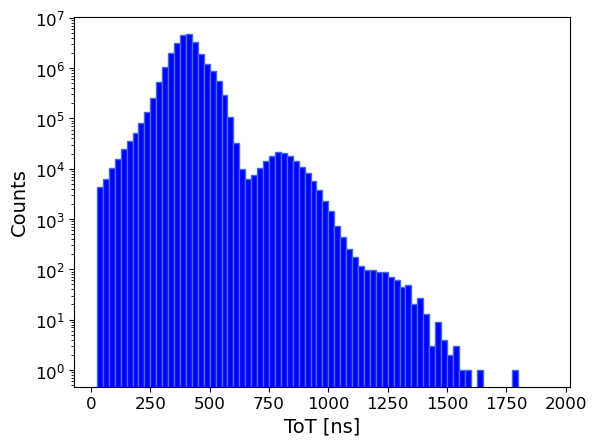

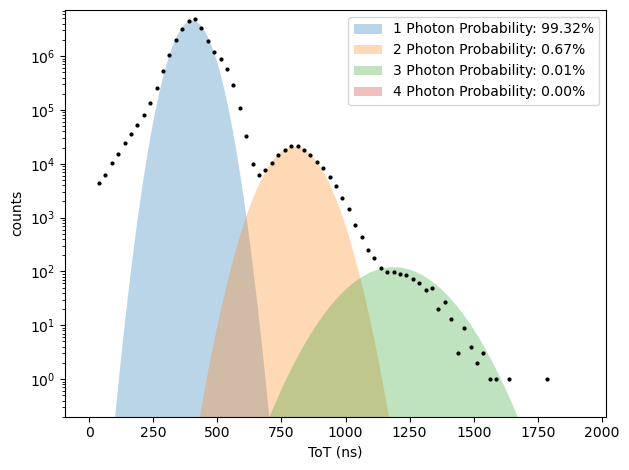

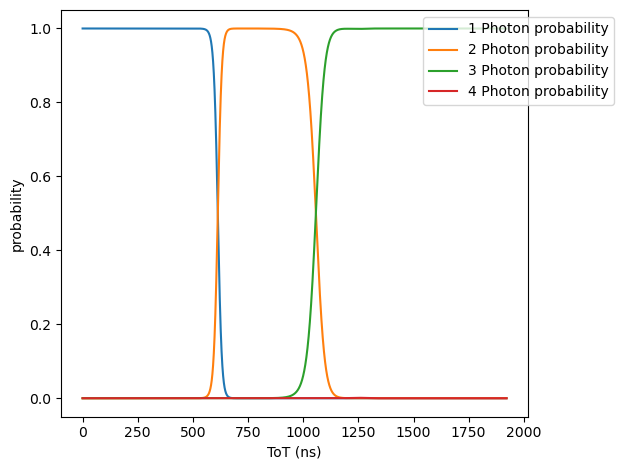

/nsls2/users/jgoodrich/gh/chx_timepix/.pixi/envs/default/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nsls2/users/jgoodrich/gh/chx_timepix/.pixi/envs/default/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


There were 4 located ToT peaks giving the following ToT threshold values for each n_photon val

[612.860263458801, 1057.5318172923762, nan]

Broad search: found optimal t_0 as 2,641.6589800 ns


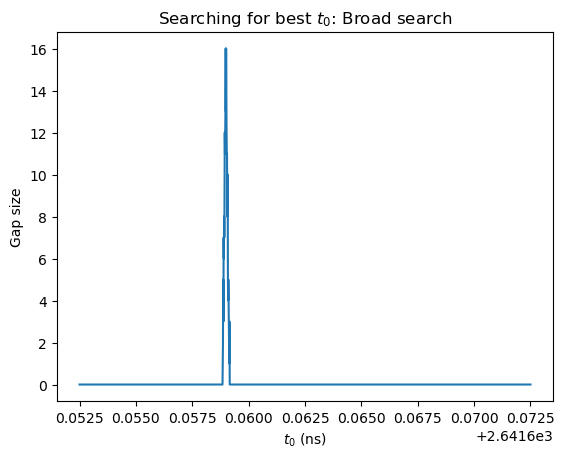

Tight search: found optimal t_0 as 2,641.6589970 ns


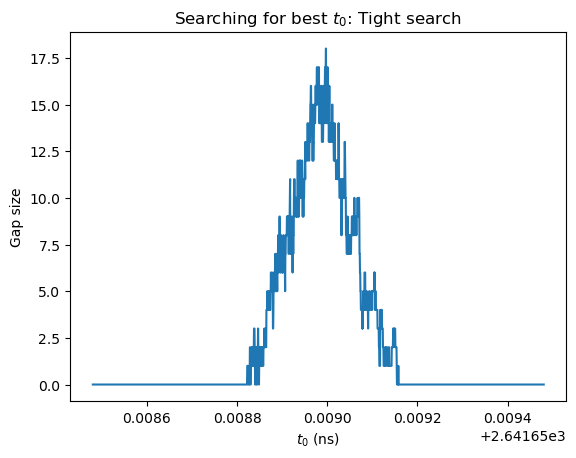

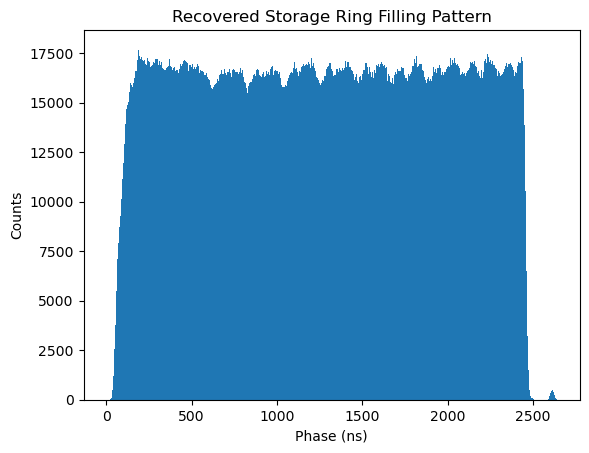

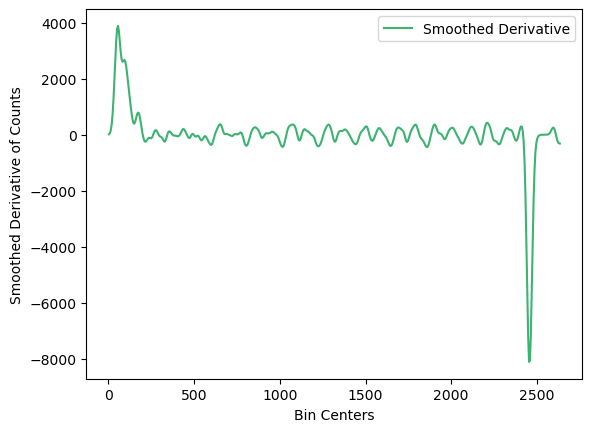

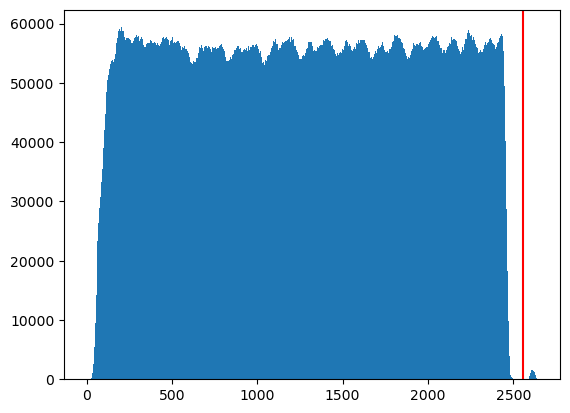

The final storage ring period was found to be 2641.6589969999995 nanoseconds!


In [6]:
N = 1# in microseconds

df_sparse, t0 = sparse_code.sparse_format(df, N=N, prints = True) 
frame_max = df_sparse.time_bin.max()+1; x_max = df.x.max()+1; y_max = df.y.max()+1
frame_data = np.zeros((frame_max, x_max, y_max), dtype=np.uint8)
frame_data[df_sparse['time_bin'].values, df_sparse['x'].values, df_sparse['y'].values] = df_sparse['n_photons'].values

In [7]:
frame_sums = np.sum(frame_data, axis=(1,2))
non_empty_mask = frame_sums != 0
frame_data_nz = frame_data[non_empty_mask]

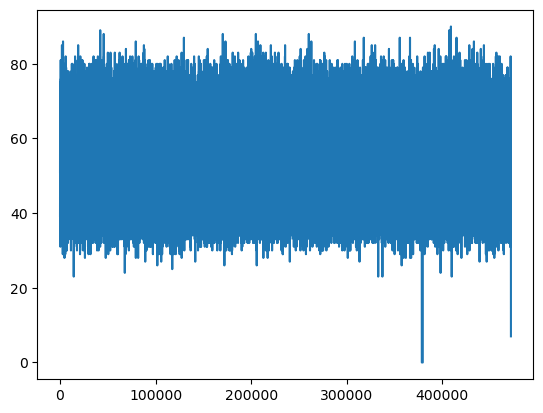

In [8]:
plt.plot(frame_sums)

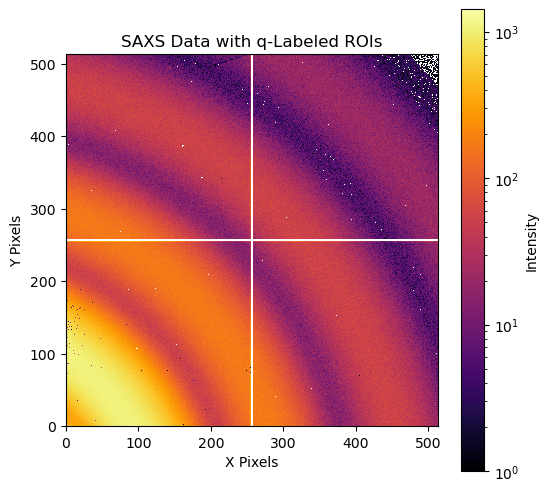

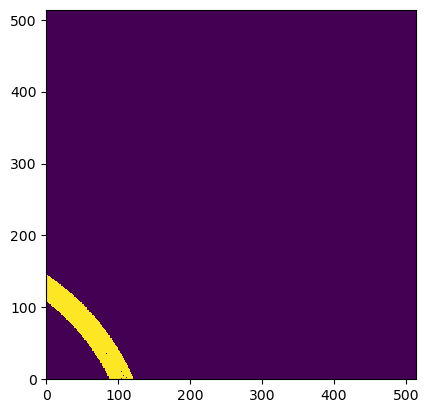

In [12]:
hist_data, xedges, yedges = np.histogram2d(df.xc, df.yc, range=[[0, 513], [0, 513]], bins=514)

# Define parameters
frame_shape = (514, 514)
height, width = frame_shape

wavelength = 1.284810346  # in Ångströms
detector_distance = 16.5  # in meters
pixel_size = 55e-6  #in meters

beam_center_y = -135  # Can be off the detector
beam_center_x = -188  # Can be off the detector

# Define q values (example values, user can modify)
q_values = np.arange(0.005, 0.006, 0.0005)
#np.array([0.0035, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015])  # in Å⁻¹

# Generate grid of indices
yy, xx = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

# Compute pixel distances from beam center
pixel_distances = np.sqrt((xx - beam_center_x) ** 2 + (yy - beam_center_y) ** 2)

# Convert q values to pixel distances
def q_to_pixel_distance(q, wavelength, detector_distance, pixel_size):
    theta = np.arcsin(q * wavelength / (4 * np.pi))  # Scattering angle
    R = np.tan(2 * theta) * detector_distance  # Convert to meters
    return R / pixel_size  # Convert to pixels

# Compute pixel distances for q values
pixel_radii = np.array([q_to_pixel_distance(q, wavelength, detector_distance, pixel_size) for q in q_values])

# Initialize mask
mask = np.zeros(frame_shape, dtype=int)

# Assign mask values for each annular region
for i in range(len(pixel_radii) - 1):
    mask[(pixel_distances >= pixel_radii[i]) & (pixel_distances < pixel_radii[i + 1])] = i + 1

fig, ax = plt.subplots(figsize=(6,6))
h = ax.pcolormesh(xedges, yedges, hist_data.T, norm=mpl_colors.LogNorm(), cmap='inferno')
fig.colorbar(h, ax=ax, label="Intensity")

# Overlay ROIs with transparency
#ax.imshow(mask, origin='lower', cmap='jet', alpha=0.5)  # Adjust alpha for opacity
ax.contour(mask, levels=np.arange(1, np.max(mask) + 1), colors='white', linewidths=1.5)

ax.set_aspect('equal')
# Titles and labels
ax.set_title("SAXS Data with q-Labeled ROIs")
ax.set_xlabel("X Pixels")
ax.set_ylabel("Y Pixels")

plt.show()

mask *= det_mask

plt.figure()
plt.pcolormesh(mask)
plt.gca().set_aspect('equal')
plt.show()

In [14]:
N_frames = frame_data.shape[0]
tbin = t0*N
print(f"Bin time is: {t0*N} ns.")

num_levels, num_bufs = recommend_multi_tau_from_frames(N_frames, tbin, default_num_bufs=8)
print(num_levels, num_bufs)
# override for faster run time
num_levels = 12

g2n, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, mask, frame_data)

Bin time is: 2641.6589969999995 ns.
17 8


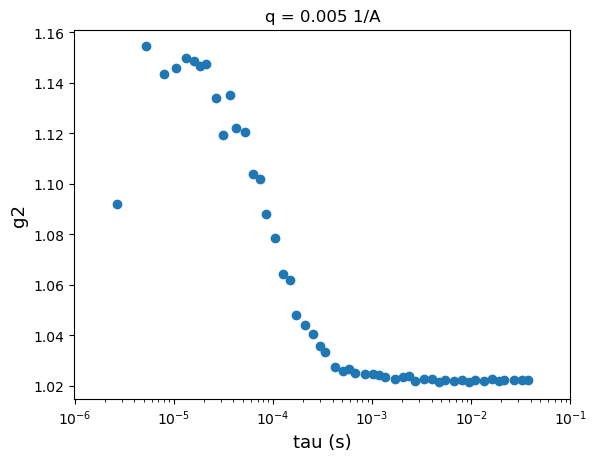

In [15]:
D_0 = calculate_D0(k_B, T, eta, a)

bb = tbin*1e-9

"""
plt.figure(figsize=(8, 5))
plt.semilogx(t_values_example * 1e6, g2_example, label=f'Theoretical $g_2(q,t)$ for q={q_example/1e10} Å$^{-1}$', color='b')
"""

for q_ind in range(g2n.shape[1]):    
    q_val = q_values[q_ind] 
    t_vals = bb*lag_steps[1:]    

    plt.figure()
    plt.semilogx(t_vals,(g2n[1:, q_ind]),'o',)
    plt.title(f'q = {q_val} 1/A')
    plt.ylabel('g2', fontsize = 13)
    plt.xlim([0.99*1e-6, 1e-1])
    plt.xlabel('tau (s)', fontsize = 13)
    plt.show()